<a href="https://colab.research.google.com/github/thabied/Personality-Prediction/blob/master/Personality_Profile_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 7 NLP Project
***

![Pic](https://i.pinimg.com/originals/2c/c9/93/2cc993328e0f5aa1c79caf6d67d3640a.png)

# Introduction
***
**The goal for this project is to predict a person's MBTI personality type**



<U>What is MBTI:</U>  Myers-Briggs theory is an adaptation of the theory of psychological types produced by Carl Gustav Jung. It is the most commonly used personlaity prediction model world wide.
 

<U>Data:</U>
The data given is from the Personality Cafe website forums of users' social media posts. There are only 2 variables. 

The Target variable Y is the MBTI 'type' classification of users, each MBTI personality type consists of four binary variables, they are: 
- Mind: Introverted (I) or Extraverted (E) 
- Energy: Sensing (S) or Intuitive (N) 
- Nature: Feeling (F) or Thinking (T) 
- Tactics: Perceiving (P) or Judging (J)

The Independant Variable X is the social media 'posts' of users. 

Each variable (independent and dependant) is analysed, determining the quality and nature of the variable’s data.


<U>Model Overview:</U>
This challenge will require the use of Natural Language Processing to convert the data into machine learning format. This data will then be used to train a classifier capable of assigning MBTI labels to a person's online forum posts.

<U>Evaluation Metric:</U>
Our submission will be scored on mean column-wise log loss across each of the four categories.

**Importing Libraries**

In [0]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_auc_score, accuracy_score


import seaborn as sns
%matplotlib inline
import re

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

**Mount Google Drive**

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/train_cl.csv')
test = pd.read_csv('/content/drive/My Drive/test_cl.csv')

In [0]:
train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


From a cursory inspection of the data we can see that posts contain:
- Multiple posts seperated by '|||'
- URLs
- Punctuation
- Higher and Lower case letters

In [0]:
test.head()

,id,posts
0,1,Musical Linguistic Logic & Naturalist (tied)|...
1,2,'You: hello :) Stranger: hii You: how are you ...
2,3,'What worked for me was knowing that limerence...
3,4,'Please forget about him. You should definitel...
4,5,"'Ooh, ENTJ Celestia is actually an interesting..."


As expected the test set has only the Independant Variable 'posts' as we  are expected to predict the MBTI personality from this

# Exploratory Data Analysis

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6506 entries, 0 to 6505
Data columns (total 2 columns):
type     6506 non-null object
posts    6506 non-null object
dtypes: object(2)
memory usage: 101.7+ KB


**Distribution of the target variable**

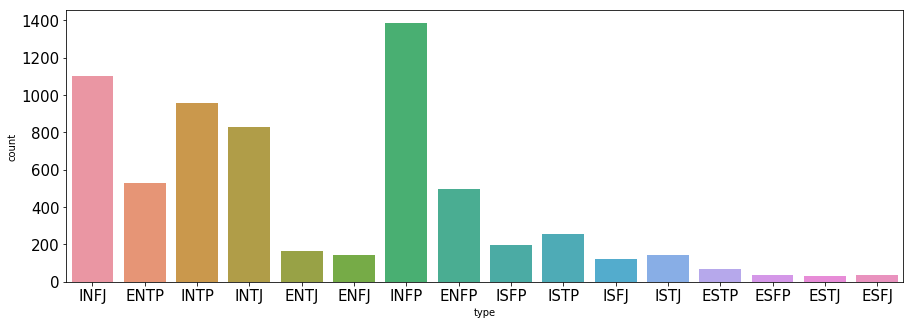

In [0]:
plt.figure(figsize=(15,5))
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
sns.countplot(data=train, x='type');

- As can be seen the data is unbalanced and we need to balance it. This is done in the modeling phase as part of Hyperparameter tuning
- What is also interesting is that in this training set Introvert is extremely over represented in comparison to Extrovert 

In [0]:
y = train['type']
test_id = test['id']

**MBTI Type Preprocessing**

Split mbti personality into 4 letters and binarize. When it comes to performing machine learning, trying to distinguish between two categories is much easier than distinguishing between 16 categories. We will check that later on. Dividing the data in 4 small groups will perhaps be more useful when it comes to accuracy.

In [0]:
train['mind'] = train['type'].map(lambda x: 'I' if x[0] == 'I' else 'E')
train['energy'] = train['type'].map(lambda x: 'N' if x[1] == 'N' else 'S')
train['nature'] = train['type'].map(lambda x: 'T' if x[2] == 'T' else 'F')
train['tactics'] = train['type'].map(lambda x: 'J' if x[3] == 'J' else 'P')

In [0]:
#Now convert the alpha chars to numeric numbers 

train['mind'] = train['mind'].apply(lambda x: 0 if x == 'I' else 1)
train['energy'] = train['energy'].apply(lambda x: 0 if x == 'S' else 1)
train['nature'] = train['nature'].apply(lambda x: 0 if x == 'F' else 1)
train['tactics'] = train['tactics'].apply(lambda x: 0 if x == 'P' else 1)

In [0]:
train.head()

,type,posts,mind,energy,nature,tactics
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,1,1,1,1


**Distribution across Types Indicators**

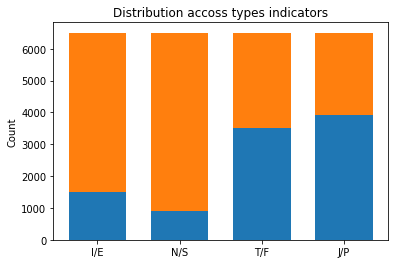

In [0]:
N = 4
but = (train['mind'].value_counts()[1], train['energy'].value_counts()[0], train['nature'].value_counts()[0], train['tactics'].value_counts()[0])
top = (train['mind'].value_counts()[0], train['energy'].value_counts()[1], train['nature'].value_counts()[1], train['tactics'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
width = 0.7      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('I/E',  'N/S', 'T/F', 'J/P',))

plt.show()

As can be seen 
- Introvert is heavily favoured in the mind category
- Intuitive is heavily favoured in the energy category
- Nature and Tactics have more even spreads 


**Concatenating the data**

We decided to concatenate the posts of the Train and Test set. In order to have  a larger data set to train the machine learning model on, as we believe this will lead to a better model. 

In [0]:
combined = pd.concat([train[['posts']].copy(), test[['posts']].copy()], axis=0)

In [0]:
combined.head()

,posts
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,'I'm finding the lack of me in these posts ver...
2,'Good one _____ https://www.youtube.com/wat...
3,"'Dear INTP, I enjoyed our conversation the o..."
4,'You're fired.|||That's another silly misconce...


# Understanding NLP

NLP is a branch of data science that consists of systematic processes for analyzing, understanding, and deriving information from the text data in a smart and efficient manner. By utilizing NLP and its components, one can organize massive chunks of text data, perform numerous automated tasks and solve a wide range of problems.

# Text PreProcessing

Text is the most unstructured form of all the available data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing.

It is predominantly comprised of three steps:

- Noise Removal
- Lexicon Normalization
- Object Standardization

![Pic](https://eng.uber.com/wp-content/uploads/2018/01/Actual-Header-2.png)


<U>**What is SpaCy**</U> 

The spaCy library is one of the most popular NLP libraries along with NLTK.
Spacy automatically breaks your document into tokens when a document is created using the model.
A token simply refers to an individual part of a sentence having some semantic value.

<U>**Why did we use SpaCy**</U>

We used the spaCy Stop Word function 


<U>**Stop Words**</U>

the stop words removal process is a one of the important step to have a better input for any models. Stop words means that it is a very common words in a language (e.g. a, an, the in English). It does not help on many NLP problem such as semantic analysis, classification etc.

In [0]:
#Function that preprocess text using Spacy
import spacy
import en_core_web_sm

from spacy.lang.en.stop_words import STOP_WORDS

#loading the en_core_web_sm_model
stopwords = STOP_WORDS
nlp = en_core_web_sm.load()
#nlp = spacy.load('en_core_web_sm')

def preprocess(train):
    #creating a Doc object
    doc = nlp(train, disable = ['ner', 'parser'])
    #Generating lemmas
    lemmas = [token.lemma_ for token in doc]
    #remove stopwords and non-alphabetic characters
    a_lemma = [lemma for lemma in lemmas
              if lemma.isalpha() and lemma not in stopwords]
    return ' ' .join(a_lemma) #.lower

#apply preprocessing to posts
combined['clean_posts'] = combined['posts'].apply(preprocess)

In [0]:
combined.head()

,posts,clean_posts
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,intj moment sportscenter play life change expe...
1,'I'm finding the lack of me in these posts ver...,find lack post bore position example girlfrien...
2,'Good one _____ https://www.youtube.com/wat...,good course know blessing absolutely positive ...
3,"'Dear INTP, I enjoyed our conversation the o...",dear INTP enjoy conversation day Esoteric gabb...
4,'You're fired.|||That's another silly misconce...,silly misconception approach logically key unl...


In [0]:
all_data = combined.copy()

In [0]:
all_data.head()

,posts,clean_posts
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,intj moment sportscenter play life change expe...
1,'I'm finding the lack of me in these posts ver...,find lack post bore position example girlfrien...
2,'Good one _____ https://www.youtube.com/wat...,good course know blessing absolutely positive ...
3,"'Dear INTP, I enjoyed our conversation the o...",dear INTP enjoy conversation day Esoteric gabb...
4,'You're fired.|||That's another silly misconce...,silly misconception approach logically key unl...


<U>**What is Lemmatization**</U> 

Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

We decided to use WordNetLemmatizer for Lemmatization.

<U>**Wordnet Lemmatizer with NLTK**</U> 

Wordnet is an large, freely and publicly available lexical database for the English language aiming to establish structured semantic relationships between words. It offers lemmatization capabilities as well and is one of the earliest and most commonly used lemmatizers.

<U>**TweetTokenizer**</U> 

The posts we are analysing are from twitter. Twitter changes the rules of tokenization because the content of a tweet includes emoticons, hashtags, user mentions, URLs, and is quite different from standard english. For this reason we used the TweetTokenizer class as a tool to tokkenize twitter content.   

In [43]:
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
tweettoken = TweetTokenizer()
wordnet = WordNetLemmatizer()

all_data['final_posts'] = all_data.apply(lambda row: [wordnet.lemmatize(w) for w in tweettoken.tokenize(row['clean_posts'])], axis=1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
all_data.head()

,posts,clean_posts,final_posts
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,intj moment sportscenter play life change expe...,"[intj, moment, sportscenter, play, life, chang..."
1,'I'm finding the lack of me in these posts ver...,find lack post bore position example girlfrien...,"[find, lack, post, bore, position, example, gi..."
2,'Good one _____ https://www.youtube.com/wat...,good course know blessing absolutely positive ...,"[good, course, know, blessing, absolutely, pos..."
3,"'Dear INTP, I enjoyed our conversation the o...",dear INTP enjoy conversation day Esoteric gabb...,"[dear, INTP, enjoy, conversation, day, Esoteri..."
4,'You're fired.|||That's another silly misconce...,silly misconception approach logically key unl...,"[silly, misconception, approach, logically, ke..."


In [0]:
all_data['final_posts']=[" ".join(post) for post in all_data['final_posts']]

In [45]:
all_data.head()

,posts,clean_posts,final_posts
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,intj moment sportscenter play life change expe...,intj moment sportscenter play life change expe...
1,'I'm finding the lack of me in these posts ver...,find lack post bore position example girlfrien...,find lack post bore position example girlfrien...
2,'Good one _____ https://www.youtube.com/wat...,good course know blessing absolutely positive ...,good course know blessing absolutely positive ...
3,"'Dear INTP, I enjoyed our conversation the o...",dear INTP enjoy conversation day Esoteric gabb...,dear INTP enjoy conversation day Esoteric gabb...
4,'You're fired.|||That's another silly misconce...,silly misconception approach logically key unl...,silly misconception approach logically key unl...


# TFIDF Vector

Scikit-learn’s <U>**Tfidfvectorizer**</U> aims to convert a collection of raw documents to a matrix of TF-IDF features. 
TF-IDF has two parts:

Term Frequency (Tf):
- How many times a particular word appears in a single doc.

Inverse Document Frequency (idf):
- Frequent and rare words is solved by adding this term.
It is calculated by taking the log of {number of docs in your corpus divided by the number of docs in which this term appears}. 
So for “the”, the ratio will be close to 1 since it is present in most (all) docs. Therefore, the log will take this ratio to 0.

Parameters:
- **min_df** When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
- **ngram_range** The lower and upper boundary of the range of n-values for different n-grams to be extracted.

In [0]:
tfidf_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,2))

In [0]:
counts = tfidf_vectorizer.fit_transform(all_data['final_posts'].values)

train_new = counts[:len(train), :]
test_new = counts[len(train):, :]

In [0]:
# Train test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_new, y, test_size=0.2)

# Training, Prediction and Evaluation

#### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)
y_pred1 = logistic.predict_proba(X_test)

from sklearn.metrics import classification_report, log_loss

print('Logistic Regression:')
print('\n\nnClassification Report:', classification_report(y_test,y_pred))
print('Log Loss:', log_loss(y_test,y_pred1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression:


nClassification Report:               precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        31
        ENFP       0.62      0.35      0.44        81
        ENTJ       1.00      0.07      0.13        28
        ENTP       0.74      0.43      0.54       105
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00         4
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        16
        INFJ       0.58      0.65      0.61       212
        INFP       0.44      0.91      0.59       259
        INTJ       0.64      0.62      0.63       162
        INTP       0.64      0.71      0.67       234
        ISFJ       0.00      0.00      0.00        26
        ISFP       1.00      0.03      0.05        38
        ISTJ       0.00      0.00      0.00        32
        ISTP       0.50      0.02      0.03        58

    accuracy                     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Naive Bayes

In [0]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_pred1 = nb.predict_proba(X_test)


from sklearn.metrics import classification_report, log_loss

print('Naive Bayes:')
print('\n\nClassification Report:\n', classification_report(y_test,y_pred))
print('Log Loss:', log_loss(y_test,y_pred1))

Naive Bayes:


Classification Report:
               precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        31
        ENFP       0.00      0.00      0.00        81
        ENTJ       0.00      0.00      0.00        28
        ENTP       0.00      0.00      0.00       105
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00         4
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        16
        INFJ       0.00      0.00      0.00       212
        INFP       0.20      1.00      0.33       259
        INTJ       0.00      0.00      0.00       162
        INTP       0.00      0.00      0.00       234
        ISFJ       0.00      0.00      0.00        26
        ISFP       0.00      0.00      0.00        38
        ISTJ       0.00      0.00      0.00        32
        ISTP       0.00      0.00      0.00        58

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred1 = rf.predict_proba(X_test)

from sklearn.metrics import classification_report, log_loss

print('Random Forest:')
print('\n\nClassification Report:\n', classification_report(y_test,y_pred))
print('Log Loss:', log_loss(y_test,y_pred1))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest:


Classification Report:
               precision    recall  f1-score   support

        ENFJ       0.20      0.03      0.06        31
        ENFP       0.23      0.26      0.24        81
        ENTJ       0.20      0.07      0.11        28
        ENTP       0.21      0.14      0.17       105
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00         4
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        16
        INFJ       0.31      0.51      0.39       212
        INFP       0.34      0.66      0.45       259
        INTJ       0.26      0.19      0.22       162
        INTP       0.31      0.20      0.24       234
        ISFJ       1.00      0.04      0.07        26
        ISFP       0.00      0.00      0.00        38
        ISTJ       0.00      0.00      0.00        32
        ISTP       1.00      0.09      0.16        58

    accuracy                           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Support Vector Classifier

In [0]:
from sklearn.svm import SVC

svc = SVC(probability=True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
y_pred1 = svc.predict_proba(X_test)

from sklearn.metrics import classification_report, log_loss

print('Support Vector Classifier:')
print('\n\nClassification Report:', classification_report(y_test,y_pred))
print('Log Loss:', log_loss(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Support Vector Classifier:


Classification Report:               precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        31
        ENFP       0.00      0.00      0.00        81
        ENTJ       0.00      0.00      0.00        28
        ENTP       0.00      0.00      0.00       105
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00         4
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        16
        INFJ       0.00      0.00      0.00       212
        INFP       0.20      1.00      0.33       259
        INTJ       0.00      0.00      0.00       162
        INTP       0.00      0.00      0.00       234
        ISFJ       0.00      0.00      0.00        26
        ISFP       0.00      0.00      0.00        38
        ISTJ       0.00      0.00      0.00        32
        ISTP       0.00      0.00      0.00        58

    accuracy                

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: ignored

Logistic Regression gives us the best log_loss score, so we will tune its hyperparameters for better result

#### Hyperparameter tuning

Grid Search was used to find 'C'

In [0]:
def tune_model(X_train, y_train): 
    
    C_list = [0.001,0.01,0.1, 1,2,5,10]
    
    log = logisticRegression()
    parameters = {'C':(C_list)}
    
    clf = GridSearchCV(log, parameters)
    best = clf.fit(X_train,y_train)
    return best.best_params_

tune_model(X_train, y_train)

For the other hyperparameters we simply read the sklearn <a href='https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'>documentation</a> descriptions and chose the 'class_weight', 'solver', 'multi_class' and 'penalty' that seemed the most appropriate.

#### Logistic Regression with hyperparameters

In [49]:
#Logistic Regression with hyperparameters
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(C=10, class_weight='balanced',solver='newton-cg', multi_class='multinomial',penalty='l2')
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)
y_pred1 = logistic.predict_proba(X_test)

from sklearn.metrics import classification_report, log_loss

print('Logisitc Regression with hyperparameters:')
print('\n\nClass Report:', classification_report(y_test,y_pred))
print('Log Loss:', log_loss(y_test,y_pred1))

Logisitc Regression with hyperparameters:


Class Report:               precision    recall  f1-score   support

        ENFJ       0.38      0.14      0.21        21
        ENFP       0.69      0.61      0.64        97
        ENTJ       0.67      0.33      0.44        30
        ENTP       0.71      0.63      0.67       110
        ESFJ       1.00      0.33      0.50         9
        ESFP       0.00      0.00      0.00         9
        ESTJ       1.00      0.25      0.40         4
        ESTP       0.71      0.36      0.48        14
        INFJ       0.67      0.68      0.67       209
        INFP       0.71      0.81      0.75       300
        INTJ       0.61      0.75      0.67       169
        INTP       0.60      0.73      0.66       190
        ISFJ       0.86      0.29      0.43        21
        ISFP       0.63      0.41      0.50        41
        ISTJ       0.43      0.24      0.31        25
        ISTP       0.79      0.64      0.71        53

    accuracy          

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Submission

### Generating Submission

In [0]:
y_logistic = logistic.predict(test_new)

In [0]:
submission_logistic = pd.DataFrame()

In [0]:
submission_logistic['id'] = test_id
submission_logistic['type'] = y_logistic

In [0]:
print(submission_logistic['type'].value_counts())

In [0]:
# Encoding the different type to each category
submission_logistic['mind'] = submission_logistic['type'].apply(lambda X: 0 if X[0] == 'I' else 1)
submission_logistic['energy'] = submission_logistic['type'].apply(lambda X: 0 if X[1] == 'S' else 1)
submission_logistic['nature'] = submission_logistic['type'].apply(lambda X: 0 if X[2] == 'F' else 1)
submission_logistic['tactics'] = submission_logistic['type'].apply(lambda X: 0 if X[3] == 'P' else 1)

In [0]:
#Preparing the dataset for submission
submission_file_logistic = submission_logistic.drop('type', axis =1)

In [0]:
#Creating a csv for each model 
submission_file_logistic.to_csv('submission_logistic_hp_all_train.csv', index = False)